In [ ]:
# default_exp chem

# Chem

> Core comp chem functions implemented with RDKit

In [ ]:
#hide
from nbdev.showdoc import *
%load_ext autoreload
%autoreload 2

In [ ]:
# export
from mrl.imports import *
from mrl.core import *
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, rdMolDescriptors, Descriptors, rdMMPA, QED, RDConfig
from rdkit.Chem.FilterCatalog import *
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
import sascorer
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

//anaconda3/envs/insight/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterCatalogEntry const> already registered; second conversion method ignored.
  return f(*args, **kwds)


## RDKit i/o

`to_mol` and `to_smile` are functions that make it easy to work with both SMILES strings and RDKit `Mol` objects. For example, if a function requires a `mol` input, adding `mol = to_mol(mol)` allows the function to take either SMILES strings or RDKit mols as input

In [ ]:
# export
def to_mol(smile_or_mol):
    if (type(smile_or_mol) == str) or (type(smile_or_mol) == np.str_):
        mol = Chem.MolFromSmiles(smile_or_mol)
        if mol is not None:
            Chem.SanitizeMol(mol)
    else:
        mol = smile_or_mol
        
    return mol

def to_smile(smile_or_mol):
    
    if type(smile_or_mol)==Chem.Mol:
        smile = Chem.MolToSmiles(smile_or_mol)
    else:
        smile = smile_or_mol
        
    return smile

def to_smart(smart_or_mol):
    
    if type(smart_or_mol)==Chem.Mol:
        smart = Chem.MolToSmarts(smart_or_mol)
    else:
        smart = smart_or_mol
        
    return smart

def to_mols(list_of_inputs):
    return maybe_parallel(to_mol, list_of_inputs)

def to_smiles(list_of_inputs):
    return maybe_parallel(to_smile, list_of_inputs)

def to_smarts(list_of_inputs):
    return maybe_parallel(to_smart, list_of_inputs)

def canon_smile(smile):
    return Chem.CanonSmiles(smile)

def neutralize_atoms(mol):
    "Neutralize charges, from rdkit.org/docs/Cookbook.html#neutralizing-molecules"
    pattern = Chem.MolFromSmarts("[+1!h0!$([*]~[-1,-2,-3,-4]),-1!$([*]~[+1,+2,+3,+4])]")
    at_matches = mol.GetSubstructMatches(pattern)
    at_matches_list = [y[0] for y in at_matches]
    if len(at_matches_list) > 0:
        for at_idx in at_matches_list:
            atom = mol.GetAtomWithIdx(at_idx)
            chg = atom.GetFormalCharge()
            hcount = atom.GetTotalNumHs()
            atom.SetFormalCharge(0)
            atom.SetNumExplicitHs(hcount - chg)
            atom.UpdatePropertyCache()
    return mol

In [ ]:
assert type(to_smile('CCC')) == str
assert type(to_mol('CCC')) == Chem.Mol
assert type(to_smile(Chem.MolFromSmiles('CCC'))) == str
assert type(to_mol(Chem.MolFromSmiles('CCC'))) == Chem.Mol

## Mol Descriptors

These are a bunch of wrappers for standard RDKit functions. The reason for doing this is RDKit functions can't be pickled, which causes all sorts of problems for multiprocessing. This is fixed by creating a wrapper function

For example:

In [ ]:
try:
    output = maybe_parallel(rdMolDescriptors.CalcExactMolWt, [to_mol('CCC')])
    print('Parallel execution succeeded')
except:
    print('parallel execution failed')
    
def wrapper(mol):
    return rdMolDescriptors.CalcExactMolWt(mol)

try:
    output = maybe_parallel(wrapper, [to_mol('CCC')])
    print('Parallel execution succeeded')
except:
    print('parallel execution failed')

parallel execution failed
Parallel execution succeeded


Sadly, having a generic wrapper constructor also fails to pickle because such a wrapper requires an RDKit function as input to construct the wrapper, which brings back the pickle problems (see code example below). This leaves us with manually defining wrapper functions for RDKit functions

In [ ]:
def rdkit_wrapper(rdkit_func):
    def wrapper(mol):
        return rdkit_func(mol)
    
    return wrapper

try:
    output = maybe_parallel(rdkit_wrapper(rdMolDescriptors.CalcExactMolWt), [to_mol('CCC')])
    print('Parallel execution succeeded')
except:
    print('parallel execution failed')

parallel execution failed


In [ ]:
# export

def molwt(mol):
    'molecular weight'
    return rdMolDescriptors.CalcExactMolWt(mol)

def hbd(mol):
    'number of hydrogen bond donors'
    return rdMolDescriptors.CalcNumHBD(mol)

def hba(mol):
    'number of hydrogen bond acceptors'
    return rdMolDescriptors.CalcNumHBA(mol)
    
def tpsa(mol):
    'total polar surface area'
    return rdMolDescriptors.CalcTPSA(mol)
    
def rotbond(mol):
    'number of rotatable bonds'
    return rdMolDescriptors.CalcNumRotatableBonds(mol)
    
def fsp3(mol):
    'fraction sp3 hybridized atoms'
    return rdMolDescriptors.CalcFractionCSP3(mol)
    
def logp(mol):
    'logp'
    return Descriptors.MolLogP(mol)
    
def rings(mol):
    'number of rings'
    return rdMolDescriptors.CalcNumRings(mol)
    
def heteroatoms(mol):
    'number of heteroatoms'
    return rdMolDescriptors.CalcNumHeteroatoms(mol)

def all_atoms(mol):
    'total number of atoms'
    mo = Chem.AddHs(mol)
    return mol.GetNumAtoms()

def heavy_atoms(mol):
    'number of heavy atoms'
    return mol.GetNumHeavyAtoms()

def formal_charge(mol):
    return mol.GetFormalCharge()

def molar_refractivity(mol):
    'molar refractivity'
    return Descriptors.MolMR(mol)

def aromaticrings(mol):
    'number of aromatic rings'
    return rdMolDescriptors.CalcNumAromaticRings(mol)

def qed(mol):
    'QED Score doi:10.1038/nchem.1243 '
    return QED.qed(mol)

def sa_score(mol):
    'Synthetic Accessability score doi.org/10.1186/1758-2946-1-8'
    return sascorer.calculateScore(mol)

In [ ]:
try:
    _ = maybe_parallel(hbd, [to_mol('CCC')])
    output = 'success'
except:
    output = 'fail'
    
assert output == 'success'

## Substructure Matching

This class is used for substructure matching an input `Mol` against a list of SMARTS. 

__Note__: Substructure matching is tricky. Be sure to verify your SMARTS before putting a large number of them into a filter.

`CatalogMatch` functions as a base class to match `Mol` objects against any generic catalog. `has_match` will return a single boolean value for if the `Mol` matches one of he filters in the catalog. `get_matches` will return a list of bools for all elements in the catalog.

`SMARTSMatch` will generate a catalog from a list of SMARTS

`PAINSMatch`, `PAINSAMatch`, `PAINSBMatch` and `PAINSCMatch` specify different PAINS catalogs present in RDKit (see [here](https://www.rdkit.org/docs/source/rdkit.Chem.rdfiltercatalog.html#rdkit.Chem.rdfiltercatalog.FilterCatalogParams.FilterCatalogs))

In [ ]:
# export
class Catalog():
    '''
    Base Class for SMARTS matching
    
    Inputs: `catalog`, RDKit `FilterCatalog`
    '''
    def __init__(self, catalog):
        self.catalog = catalog
        self.names = [self.catalog.GetEntryWithIdx(i).GetDescription() 
                      for i in range(self.catalog.GetNumEntries())]
            
    def __call__(self, mol, criteria='any'): 
        assert criteria in ('any', 'all'), "criteria must be one of ('any', 'all')"
        if criteria=='all':
            output = maybe_parallel(self.get_matches, mol)
        else:
            output = maybe_parallel(self.has_match, mol)
            
        return output
        
    def has_match(self, mol):
        mol = to_mol(mol)
        return self.catalog.HasMatch(mol)
    
    def get_matches(self, mol):
        mol = to_mol(mol)
        matches = [i.GetDescription() for i in self.catalog.GetMatches(mol)]
        return [i in matches for i in self.names]
    
class SmartsCatalog(Catalog):
    '''
    Class for SMARTS matching
    
    Inputs: `smarts`, list of smarts
    '''
    def __init__(self, smarts):
        self.smarts = smarts
        catalog = FilterCatalog()
        for s in smarts:
            catalog.AddEntry(FilterCatalogEntry(s, SmartsMatcher(s,s)))
            
        super().__init__(catalog)
        
    def get_matches(self, mol):
        mol = to_mol(mol)
        matches = [i.GetDescription() for i in self.catalog.GetMatches(mol)]
        return [i in matches for i in self.smarts]
        
        
class ParamsCatalog(Catalog):
    '''
    Generates `CatalogMatch` object from `params`, a `FilterCatalogParams` object
    '''
    def __init__(self, params):
        p = FilterCatalogParams()
        p.AddCatalog(params)
        catalog = FilterCatalog(params)
        super().__init__(catalog)
        
class PAINSCatalog(ParamsCatalog):
    "Full PAINS filter matching"
    def __init__(self):
        super().__init__(FilterCatalogParams.FilterCatalogs.PAINS)
        
class PAINSACatalog(ParamsCatalog):
    "PAINS A filter matching"
    def __init__(self):
        super().__init__(FilterCatalogParams.FilterCatalogs.PAINS_A)
        
class PAINSBCatalog(ParamsCatalog):
    "PAINS B filter matching"
    def __init__(self):
        super().__init__(FilterCatalogParams.FilterCatalogs.PAINS_B)
        
class PAINSCCatalog(ParamsCatalog):
    "PAINS C filter matching"
    def __init__(self):
        super().__init__(FilterCatalogParams.FilterCatalogs.PAINS_C)

class ZINCCatalog(ParamsCatalog):
    "ZINC filter matching"
    def __init__(self):
        super().__init__(FilterCatalogParams.FilterCatalogs.ZINC)
        
class BRENKCatalog(ParamsCatalog):
    "BRENK filter matching"
    def __init__(self):
        super().__init__(FilterCatalogParams.FilterCatalogs.BRENK)

In [ ]:
smarts = [
    '[*]-[#6]1:[#6]:[#6](-[#0]):[#6]:[#6](-[*]):[#6]:1',
    '[*]-[#6]1:[#6]:[#6](-[*]):[#6]:[#6]:[#6]:1',
    '[*]-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1',
    '[*]-[#6]1:[#6]:[#6](-[#7]-[*]):[#6]:[#6]:[#6]:1',
    '[#6]1:[#6]:[#7]:[#6]:[#6]:[#6]:1'
]

sm = SmartsCatalog(smarts)

smiles = [
    'c1ccccc1',
    'Cc1cc(NC)ccc1',
    'Cc1cc(NC)cnc1',
    'Cc1cccc(NCc2ccccc2)c1'
]

mols = [to_mol(i) for i in smiles]

assert sm(mols) == [False, True, True, True]

## Fingerprints

This section deals with creating and manipulating molecular fingerprints. Below are functions for generating different forms of Morgan fingerprints (ECFP4, ECFP6, FCFP4, FCFP6). Fingerprints by default are generated as RDKit `ExplicitBitVect` objects, but can be converted to numpy arrays using the `fp_to_array` function.

Fingerprint similarity functions using Tanimoto, Dice and Cosine metrics are implemented for both `ExplicitBitVect` and `ndarray` objects.

__Note__ following cheminformatics convention, fingerprint metrics are implemented as _similarities_ rather than _distances_. The metrics used have the relationship `similarity = 1 - distance`. For using fingerprint difference metrics in machine learning applications, be sure you are using the correct relationship (similarity vs difference) for your task.

In [ ]:
# export

def morgan_fp(mol, radius=3, nbits=2048, use_features=False):
    "morgan fingerprint"
    mol = to_mol(mol)
    fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius, nBits=nbits, useFeatures=use_features)
    return fp

def ECFP4(mol):
    "ECFP4 Fingerprint"
    return morgan_fp(mol, radius=2, use_features=False)

def ECFP6(mol):
    "ECFP6 Fingerprint"
    return morgan_fp(mol, radius=3, use_features=False)

def FCFP4(mol):
    "FCFP4 Fingerprint"
    return morgan_fp(mol, radius=2, use_features=True)

def FCFP6(mol):
    "FCFP6 Fingerprint"
    return morgan_fp(mol, radius=3, use_features=True)

def fp_to_array(fp):
    "Converts RDKit `ExplicitBitVec` to numpy array"
    fp = np.asarray(fp, dtype=np.int8)

    return fp

def tanimoto(fps1, fps2):
    'Tanimoto similarity'
    return 1-distance.cdist(fps1, fps2, metric='jaccard')

def tanimoto_rd(fp, fps):
    return DataStructs.BulkTanimotoSimilarity(fp, fps)

def dice(fps1, fps2):
    'Dice similarity'
    return 1-distance.cdist(fps1, fps2, metric='dice')

def dice_rd(fp, fps):
    return DataStructs.BulkDiceSimilarity(fp, fps)

def cosine(fps1, fps2):
    'Cosine similarity'
    return 1-distance.cdist(fps1, fps2, metric='cosine')

def cosine_rd(fp, fps):
    return DataStructs.BulkCosineSimilarity(fp, fps)

When computing similarities between fingerprints, several things need to be lined up. Different methods are needed for different fingerprint formats (`ndarray` vs `ExplicitBitVect`) and different distance metrics.

The `FP` class holds logic to make this easy. 

The `FP.get_fingerprint` function allows for parallel processing of fingerprint generation.

The `FP.fingerprint_similaity` routes fingerprints to the correct similarity function based on the fingerprint's array type and the simillarity metric used.

For cases where instantiating a class isn't helpful, `get_fingerprint` and `fingerprint_similarities` work as functional wrappers around `FP`.

In [ ]:
# export

class FP():
    '''
    FP - class for manipulating molecular fingerprints
    
    `fp = FP()`
    
    `mol_fp = fp.get_fingerprint(mol, 'ECFP6')`
    '''
    def __init__(self):
        self.similarities = {
            'tanimoto' : {'rdkit' : tanimoto_rd,
                          'numpy' : tanimoto},
            'dice'     : {'rdkit' : dice_rd,
                          'numpy' : dice},
            'cosine'   : {'rdkit' : cosine_rd,
                          'numpy' : dice}
        }
        
        self.fps = {'ECFP4' : ECFP4,
                    'ECFP6' : ECFP6,
                    'FCFP4' : FCFP4,
                    'FCFP6' : FCFP6}
        
    def get_fingerprint(self, mol, fp_type='ECFP6', output_type='rdkit'):
        '''
        Generates fingerprint for `mol`.
        
        `mol` can either be a `Mol` object or a list of `Mol` objects
        '''
        method = self.fps[fp_type]

        fps = maybe_parallel(method, mol)

        if output_type == 'numpy':
            fps = fp_to_array(fps)

        return fps
    
    def fingerprint_similaity(self, fps1, fps2, metric):
        '''
        Computes the similarity between `fps1` and `fps2` using `metric`
        
        Inputs `fps1` and `fps2` can be any of the following:
            `ndarray` Numpy vector (ndim=1) single fingerprint
            `ndarray` Numpy matrix (ndim=2) of stacked fingerprints
            `ExplicitBitVect` RDKit explicit bit vec
            `list` of `ExplicitBitVect`
            
        Both `fps1` and `fps2` should have the same array type (`ndarray` or `ExplicitBitVec`)
        '''
        input_type = self._np_or_rd(fps1)
        
        metric = self.similarities[metric][input_type]
        
        if input_type == 'numpy':
            fps1 = self._maybe_stack(fps1)
            fps2 = self._maybe_stack(fps2)
            
            similarities = self._fp_similarity_numpy(fps1, fps2, metric)
            
        else:
            fps1 = self._maybe_list(fps1)
            fps2 = self._maybe_list(fps2)
        
            similarities = self._fp_similarity_rdkit(fps1, fps2, metric)
            
        return similarities
    
    def _maybe_stack(self, inp):
        "helper function to prepare numpy fingerprints"
        if type(inp)==list:
            inp = np.stack(inp)
            
        if inp.ndim == 1:
            inp = inp[None,:]
        
        return inp
    
    def _maybe_list(self, inp):
        "helper function to prepare rdkit fingerprints"
        if type(inp) == DataStructs.cDataStructs.ExplicitBitVect:
            inp = [inp]
            
        return inp
    
    def _fp_similarity_rdkit(self, fps1, fps2, metric):
        'FP similarity using RDKit methods'
        similarities = []

        for fp in fps1:
            dist = metric(fp, fps2)
            similarities.append(dist)

        return np.squeeze(np.array(similarities))
    
    def _fp_similarity_numpy(self, fps1, fps2, metric):
        'FP similarity using Numpy methods'
        return np.squeeze(metric(fps1, fps2))
    
    def _np_or_rd(self, inp):
        if type(inp) == np.ndarray:
            output = 'numpy'
        elif type(inp) == list:
            output = self._np_or_rd(inp[0])
        else:
            output = 'rdkit'

        return output
    
def get_fingerprint(mol, fp_type, output_type='rdkit'):
    fp = FP()
    return fp.get_fingerprint(mol, fp_type, output_type=output_type)

def fingerprint_similarities(fps1, fps2, metric):
    fp = FP()
    return fp.fingerprint_similarity(fps1, fps2, metric)

In [ ]:
fp = FP()
fps = fp.get_fingerprint(mols, fp_type='ECFP4', output_type='rdkit')
fps_np = fp_to_array(fps)

assert np.allclose(fp.fingerprint_similaity(fps, fps, 'tanimoto'), 
                   fp.fingerprint_similaity(fps_np, fps_np, 'tanimoto'))

## Custom Fingerpint Functions

Here is an example on how to add new fingerprint functions and distance functions

In [ ]:
# new fingerprint function

def my_fp(mol):
    mol = to_mol(mol)
    fp =  AllChem.RDKFingerprint(mol)
    return fp

class MyFP(FP):
    def __init__(self):
        super().__init__()
        self.fps['my_fp'] = my_fp
        
fp = MyFP()
fps = fp.get_fingerprint(mols, fp_type='my_fp', output_type='rdkit')

In [ ]:
# new distance function

def my_dist(fps1, fps2):
    # make sure your distance function works on binary/boolean arrays!!
    return 1-distance.cdist(fps1, fps2, metric='russellrao')

def my_dist_rd(fp, fps):
    # make sure the RDKit method gives the same result as scipy, not always the case
    return DataStructs.BulkRusselSimilarity(fp, fps)

class MyFP(FP):
    def __init__(self):
        super().__init__()
        self.similarities['my_metric'] = {'rdkit' : my_dist_rd,
                                          'numpy' : my_dist}
                
fp = MyFP()
fps = fp.get_fingerprint(mols, fp_type='ECFP6', output_type='numpy')
fp.fingerprint_similaity(fps, fps, 'my_metric')

array([[0.00195312, 0.00097656, 0.00048828, 0.00146484],
       [0.00097656, 0.01123047, 0.00585938, 0.00830078],
       [0.00048828, 0.00585938, 0.01171875, 0.00439453],
       [0.00146484, 0.00830078, 0.00439453, 0.01806641]])

## Mol Operations

Functions for editing or manipulating `Mol` objects.

Fragmenting functions like `fragment_smile` break molecules into fragments by cutting single bonds.

`fuse_on_atom_mapping` fuses fragments following RDKit's atom mapping conventions.

`[*:1]-R1-[*:2] + [*:1]-R2 >> [*:2]-R1-R2`

`fuse_on_link` relies on user-defined linkages such as heavy atoms.

`[Rb]-R1-[Pb] + [Rb]-R2 >> [Pb]-R1-R2`

In [ ]:
# export

def fragment_mol(mol, max_cuts, return_mols=False):
    'Wrapper for RDKit mol fragmentation'
    return rdMMPA.FragmentMol(mol, maxCuts=max_cuts, resultsAsMols=return_mols)

def fragment_smile(smile, cuts):
    '''
    fragment_smile - fragment `smile` based on `cuts`
    
    `smile` - str, smiles string to fragment
    
    `cuts` - int, list of ints. Number of cuts to make. If list, 
     code iterates over items in `cuts` and generates fragments from each value. 
     Note that the RDKit fragmentation uses only a single cut value. So fragmenting with 
     5 cuts will not include the result of fragmenting with 4 cuts
    '''
    mol = to_mol(smile)
    Chem.rdmolops.RemoveStereochemistry(mol)
    
    if type(cuts)==int:
        frags = fragment_mol(mol, cuts, return_mols=False)
        frags = deduplicate_list(flatten_list_of_lists(frags))
    else:
        frags = []
        for cut in cuts:
            f = fragment_mol(mol, cut, return_mols=False)
            f = deduplicate_list(flatten_list_of_lists(f))
            frags += f
        
        frags = deduplicate_list(frags)

    p = re.compile('\[\*(.*?)]')
    
    clean_frags = []
    
    for frag in frags:
        if frag: # case of ''
            frag = p.sub('[*]', frag)
            frag = Chem.CanonSmiles(frag)
            if '.' in frag:
                frag = frag.split('.')
            else:
                frag = [frag]
                
            frag = [canon_smile(i) for i in frag]
            clean_frags += frag
            
    clean_frags = deduplicate_list(clean_frags)
    
    return clean_frags

def fragment_smiles(smiles, cuts):
    'fragment and deduplicate a list of smiles'
    frags = maybe_parallel(fragment_smile, smiles, cuts=cuts)
    frags = deduplicate_list(flatten_list_of_lists(frags))
    return frags

In [ ]:
fragment_smile('CCCCCCCC', [1])

['*CCC', '*CC', '*CCCCC', '*CCCCCC', '*C', '*CCCC', '*CCCCCCC']

In [ ]:
# export
def fuse_on_atom_mapping(fragment_string):
    '''
    Inputs: `fragment_string`, str or Chem.Mol
    
    Outputs: str
    
    Merges a series of molecular fragments into a single compound by atom mapping
    
    ie `R1-[*:1].R2-[*:1] >> R1-R2`
    
    Fragments with paired atom mappings will be fused on the atoms connected to the mapped dummies.
    Mappings that occur once or more than 2 times are ignored
    '''

    mol = to_mol(fragment_string)

    new_mol = Chem.RWMol(mol)

    maps = defaultdict(list)
    for atom in new_mol.GetAtoms():
        atom_map = atom.GetAtomMapNum()
        if atom_map and atom.GetAtomicNum()==0:
            maps[atom_map].append(atom)

    remove_idxs = []
    missing = []

    for map_num in maps.keys():
        atoms = maps[map_num]
        if len(atoms) == 2:
            atom1, atom2 = atoms

            neighbor1_idx = atom1.GetNeighbors()[0].GetIdx()
            neighbor2_idx = atom2.GetNeighbors()[0].GetIdx()
            atom1_idx = atom1.GetIdx()
            atom2_idx = atom2.GetIdx()
            bond_order = atom2.GetBonds()[0].GetBondType()

            new_mol.AddBond(neighbor1_idx,
                         neighbor2_idx,
                         order=bond_order)

            remove_idxs += [atom1_idx, atom2_idx]

        elif len(atoms) == 1:
            missing.append(map_num)

    for idx in sorted(remove_idxs)[::-1]:
        new_mol.RemoveAtom(idx)

    new_smile = Chem.MolToSmiles(new_mol.GetMol())

    return new_smile

In [ ]:
assert fuse_on_atom_mapping('[*:1]CC.[*:1]CC') == 'CCCC'
assert fuse_on_atom_mapping(to_mol('[*:1]CC.[*:1]CC')) == 'CCCC'
assert fuse_on_atom_mapping('[*:1]CC.[*:2]CC') == 'CC[*:1].CC[*:2]'

In [ ]:
# export
def fuse_on_link(fragment_string, links):
    '''
    Inputs: `fragment_string`, str or Chem.Mol, `links`, list of defines linkages
    
    Outputs: str
    
    Merges a series of molecular fragments into a single compound by `links`
    
    ie `fuse_on_link('R1-[Rb].R2-[Rb]', ['[Rb]']) >> 'R1-R2'`
    
    Fragments matching a given link are defined by substring searching. 
    Links that occur once or more than 2 times are ignored
    
    Note: inputs with RDKit atom mapping (ie `[*:1]CC`) will fail
    '''
    fragment_string = to_smile(fragment_string)
    fragments = fragment_string.split('.')
    
    for link in links:
        to_link = [i for i in fragments if link in i]
        
        if len(to_link)==2:
            reaction = AllChem.ReactionFromSmarts(f'[*:1]-{link}.{link}-[*:2]>>[*:1]-[*:2]')
            new_smiles = Chem.MolToSmiles(reaction.RunReactants([Chem.MolFromSmiles(i) for i in to_link])[0][0])
            fragments = [new_smiles] + [i for i in fragments if not i in to_link]
            
    fused = to_mol('.'.join(fragments))
    return to_smile(fused)

In [ ]:
assert fuse_on_link('[Rb]CC.[Rb]CC', ['[Rb]']) == 'CCCC'
assert fuse_on_link('[Rb]CC.[Rb]CC', ['[Pb]']) == 'CC[Rb].CC[Rb]'

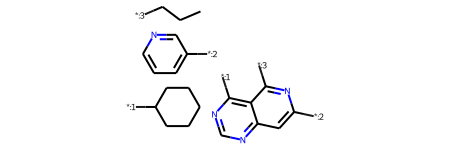

In [ ]:
fragment_smile = 'C1CCC([*:1])CC1.C([*:3])CC.c1cncc([*:2])c1.c1nc([*:1])c2c([*:3])nc([*:2])cc2n1'
mol = to_mol(fragment_smile)
mol

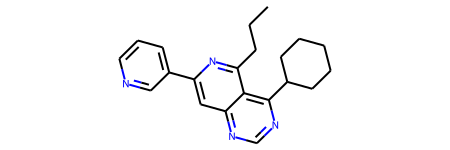

In [ ]:
fused_smile = fuse_on_atom_mapping(fragment_smile)
new_mol = to_mol(fused_smile)
new_mol

## Structure Enumeration

Often it can be useful to enumerate variants of the same core structure. For example, generating every 6 member ring variant with 2 nitrogens. The `StructureEnumerator` class provides a way of enumerating over a core structure defined by a smarts string and a set of user inputs. The structure enumerator can also add wildcard atoms.

For examples on using the `StructureEnumerator` class, see the Structure Enumeration tutorial page

In [ ]:
# export

def add_map_nums(mol):
    'Adds map numbers to all atoms in `mol`'
    mol = to_mol(mol)
    
    for i, atom in enumerate(mol.GetAtoms()):
        atom.SetAtomMapNum(i+1)
    
    return mol

def check_ring_bonds(smile):
    'Looks for SP hybridized atoms in rings'
    mol = to_mol(smile)
    for atom in mol.GetAtoms():
        if atom.GetHybridization()==Chem.rdchem.HybridizationType.SP and atom.IsInRing():
            return False
        
    return True


def decorate_smile(smile, num_attachments):
    '''
    decorate_smiles - adds wildcard atoms to smile based on num_attachments. 
     If there are N atoms with at lest one implicit hydrogen, N choose num_attachments 
     combinations are generated
    '''
    mol = to_mol(smile)

    to_decorate = []
    for atom in mol.GetAtoms():
        if atom.GetNumImplicitHs()>0:
            to_decorate.append(atom.GetIdx())

    decorated = []
    if len(to_decorate)>=num_attachments:
        dec_combos = list(itertools.combinations(to_decorate, num_attachments))

        for dc in dec_combos:
            new_mol = Chem.RWMol(mol)
            for atom_id in dc:
                new_id = new_mol.AddAtom(Chem.Atom('*'))
                new_mol.AddBond(atom_id, new_id, Chem.rdchem.BondType.SINGLE)

            new_mol = new_mol.GetMol()
            Chem.SanitizeMol(new_mol)
            decorated.append(to_smile(new_mol))

    return decorated

def decorate_smiles(smiles, num_attachments):
    "Decorate all items in `smiles` and cleans results"
    decorated = [decorate_smile(i, num_attachments) for i in smiles]        
    decorated = [i for i in decorated if i]
    decorated = flatten_list_of_lists(decorated)
    decorated = deduplicate_list(decorated)
    return decorated

def remove_atom(rwmol, atom_idx, add_bond=True):
    '''
    remove_atom - removes atom based on `atom_idx`. If `add_bond` and the removed
     atom is connected to two other heavy atoms, a single bond is formed between neighbors
    '''
    atom = rwmol.GetAtomWithIdx(atom_idx)
    bonds = atom.GetBonds()

    if len(bonds)==1:
        rwmol.RemoveAtom(atom_idx)
    elif len(bonds)==2 and add_bond:
        neighbors = atom.GetNeighbors()
        n1 = neighbors[0].GetIdx()
        n2 = neighbors[1].GetIdx()
        rwmol.AddBond(n1, n2, order=Chem.rdchem.BondType.SINGLE)
        rwmol.RemoveAtom(atom_idx)
    else:
        pass

    return rwmol

def generate_spec_template(mol):
    'generates blank atom_spec and bond_spec for mol. returns blank specs and matching smarts'
    mol = add_map_nums(mol)
    
    atom_spec = {atom.GetAtomMapNum():[] for atom in mol.GetAtoms()}
    bond_spec = {(bond.GetBeginAtom().GetAtomMapNum(), bond.GetEndAtom().GetAtomMapNum()):[]
                 for bond in mol.GetBonds()}
    
    return atom_spec, bond_spec, to_smart(mol)


class StructureEnumerator():
    '''
    StructureEnumerator - class for enumerating molecular structures
    
    Inputs:
    
        `smarts` - str, base smarts string to enumerate
        
        `atom_spec` - dict of the form `{atom_map_num:[allowed_atom_types]}` where elements in 
         `allowed_atom_types` match keys in `self.atom_types`
            
        `bond_spec` - dict of the form `{(bond_start_map_num, bond_end_map_num) : [possible_bond_types]}` 
         where elements in `possible_bond_types` match keys in `self.bond_types`
         
         `max_num` - int, max number of combinations to iterate
         
         `substitute_bonds` - None, list. List of bond types for new bonds formed from removing atoms. 
          Bond types should match keys in `self.bond_types`. If None, all keys in `self.bond_types` are used
    '''
    atomic_types = {
                    'H':1,
                    'C':6,
                    'N':7,
                    'O':8,
                    'F':9,
                    'Cl':17,
                    'Br':35
                    }

    bond_types = {'single':Chem.rdchem.BondType.SINGLE,
                  'double':Chem.rdchem.BondType.DOUBLE,
                  'triple':Chem.rdchem.BondType.TRIPLE,
                  'aromatic':Chem.rdchem.BondType.AROMATIC}
    
    def __init__(self, smarts, atom_spec, bond_spec, max_num=1000000, substitute_bonds=None):
        
        self.smarts = smarts
        self.base_mol = Chem.MolFromSmarts(smarts)
        self.atom_spec = atom_spec
        self.bond_spec = bond_spec
        self.max_num = max_num
        self.clean_specs()
        self.get_ring_info()
        
        if substitute_bonds is not None:
            self.substitute_bonds = substitute_bonds
        else:
            self.substitute_bonds = list(self.bond_types.keys())
        
        key_list = list(atom_spec.keys()) + list(bond_spec.keys())
        self.key_to_idx = {key_list[i] : i for i in range(len(key_list))}
        
        # generate combinations based on atom_spec and bond_spec
        self.iterator = itertools.product(*(list(atom_spec.values()) + list(bond_spec.values())))
        self.num_combos = np.prod([len(i) for i in list(atom_spec.values()) + list(bond_spec.values())])
        
        # write combinations into memory
        self.combos = []
        
        for combo in self.iterator:
            combo = dict(zip(self.key_to_idx.keys(), combo))
            if self.check_combo_ring(combo):
                self.combos.append(combo)
                
            if len(self.combos)>max_num:
                break
        
#         if self.num_combos < max_num:
#             self.combos = list(self.iterator)
#         else:
#             self.combos = []
#             for i in range(max_num):
#                 self.combos.append(next(self.iterator))
                
#         self.combos = [dict(zip(self.key_to_idx.keys(),i)) for i in self.combos]
        
        # check conditions for atom removal
        self.check_removals()
        # update combos based on atom removal
        self.combos = flatten_list_of_lists([self.check_combo(i) for i in self.combos])
        
    def filter_combos(self, filter_func):
        outputs = maybe_parallel(filter_func, self.combos)
        self.combos = [self.combos[i] for i in range(len(self.combos)) if outputs[i]]
        
    def clean_specs(self):
        'cleans empty entries from `atom_spec` and `bond_spec`'
        
        atom_remove = []
        bond_remove = []
        for k,v in self.atom_spec.items():
            if not v:
                atom_remove.append(k)
                
        for k,v in self.bond_spec.items():
            if not v:
                bond_remove.append(k)
                
        for k in atom_remove:
            self.atom_spec.pop(k)
            
            
        for k in bond_remove:
            self.bond_spec.pop(k)
            
    def check_combo_ring(self, combo):
        
        if -1 in combo.values():
            return True
        
        bad_bonds = [['DOUBLE', 'DOUBLE'], ['SINGLE', 'TRIPLE'], ['TRIPLE', 'SINGLE']]
        
        for ring in self.ring_dicts:
            ring = ring.copy()
            for k,v in combo.items():
                if k in ring.keys():
                    ring[k] = v
                    
            arom_bonds = [v for k,v in ring.items() if v=='aromatic']
            if 0<len(arom_bonds)<len(ring.keys()):
                # not all bonds in ring are aromatic
                return False
            
            atom_validation = defaultdict(list)
            for k,v in ring.items():
                a1,a2 = k
                atom_validation[a1].append(v)
                atom_validation[a2].append(v)
                
            for k,v in atom_validation.items():
                if v in bad_bonds:
                    # SP atoms in rings
                    return False
                
        return True
            
    def get_ring_info(self):
        self.base_mol.UpdatePropertyCache()
        Chem.GetSymmSSSR(self.base_mol)
        ring_info = self.base_mol.GetRingInfo()
        self.ring_dicts = []
        bonds = list(self.base_mol.GetBonds())
        
        for ring in ring_info.BondRings():
            ring_bonds = [bonds[i] for i in ring]
            ring_dict = {(i.GetBeginAtom().GetAtomMapNum(), 
                          i.GetEndAtom().GetAtomMapNum()): str.lower(i.GetBondType().__str__())
                         for i in ring_bonds}
            self.ring_dicts.append(ring_dict)
        
    def check_removals(self):
        '''
        check_removals
        
        If atoms removals are possible in the given atom_spec, a new bond may be added. 
         If the removed atom has the form `R1-atom_to_remove-R2`, the ouput will be `R1-R2`. 
         This function determines the map numbers of the removed bonds and the added bonds
        '''
        self.removal_dict = {}
        
        for map_num, values in self.atom_spec.items():
            if -1 in values:
                atom = [i for i in self.base_mol.GetAtoms() if i.GetAtomMapNum()==map_num][0]
                bonds = atom.GetBonds()
                if len(bonds)==2:
                    
                    neighbors = atom.GetNeighbors()
                    n1 = neighbors[0].GetAtomMapNum()
                    n2 = neighbors[1].GetAtomMapNum()
                    new_bond = (n1,n2)
                    removed_bonds = [(n1,map_num), (n2,map_num)]
                    
                    self.removal_dict[map_num] = {'new_bond':new_bond,
                                                  'removed_bonds':removed_bonds}
                    
    def check_combo(self, combo):
        '''
        If a combination contains atom removal, the combination is updated to remove 
         deleted bonds and create a new bond
        '''
        c_out = []
        for removal_num in self.removal_dict.keys():
            if combo[removal_num]==-1:
                removed_bonds = self.removal_dict[removal_num]['removed_bonds']
                for rb in removed_bonds:
                    n1, n2 = rb
                    if (n1,n2) in combo.keys():
                        combo.pop((n1,n2))
                    if (n2,n1) in combo.keys():
                        combo.pop((n2,n1))
                        
                added_bond = self.removal_dict[removal_num]['new_bond']
                for new_bondtype in self.substitute_bonds:
                    new_combo = combo.copy()
                    new_combo[added_bond] = new_bondtype
                    c_out.append(new_combo)
                    
        if not c_out:
            c_out = [combo]
            
        return c_out
                
                    
    def _create_mols(self, combos):
        "Creates smiles strings from `combos` and cleans up results"
        
        raw_smiles = maybe_parallel(self.create_mol, combos)
        clean_smiles = []
        
        for s in raw_smiles:
            if type(s)==str and ':' in s:
                s = s.replace(':', '=') # convert incomplete aromatic rings to double bonds
                m = to_mol(s)
                if m is None:
                    s = None
                
            if s is not None and check_ring_bonds(s):
                clean_smiles.append(s)
        
        smiles = deduplicate_list(clean_smiles)
        return smiles
    
    def create_mols(self, max_num=None):
        '''
        Creates `max_num` smiles strings from `self.combos` and cleans up results.
        
        More memory efficient for >1000000 combos
        '''
        if max_num is None:
            max_num = self.max_num
            
        return self._create_mols(self.combos[:max_num])

    
    def create_mols_chunks(self, chunksize):
        "Creates mols from `self.combos` in batches of `chunksize`"
        combo_chunks = chunk_list(self.combos, chunksize)
        
        smiles = []
        for i, chunk in enumerate(combo_chunks):
            print(i)
            smiles_iter = self._create_mols(chunk)
            smiles += smiles_iter
            
        smiles = deduplicate_list(smiles)
        return smiles
    
    def create_mol(self, code):
        "Edits `self.base_mol` depending on `code`"
        new_mol = Chem.RWMol(self.base_mol)
        
        atoms_to_remove = []
        # iterate atoms
        for atom in new_mol.GetAtoms():
            map_num = atom.GetAtomMapNum()
            if map_num in code.keys():
                atom_code = code[map_num]
                if atom_code == -1:
                    atoms_to_remove.append(atom.GetAtomMapNum())
                else:
                    atom_id = self.atomic_types[atom_code]
                    atom.SetAtomicNum(atom_id)
                    
        for map_num in atoms_to_remove:
            atom_idx = [i.GetIdx() for i in new_mol.GetAtoms() if i.GetAtomMapNum()==map_num][0]
            remove_atom(new_mol, atom_idx)
        
        bonds_to_remove = []
        # iterate bonds
        for bond in new_mol.GetBonds():
            start = bond.GetBeginAtom().GetAtomMapNum()
            end = bond.GetEndAtom().GetAtomMapNum()
            
            if (start, end) in code.keys():
                bond_code = code[(start, end)]
            elif (end, start) in code.keys():
                bond_code = code[(end, start)]
            else:
                bond_code = None
                
            if bond_code is not None:
                if bond_code == -1:
                    bonds_to_remove.append((bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()))
                else:
                    bond.SetBondType(self.bond_types[bond_code])
                
        for atom in new_mol.GetAtoms():
            atom.ClearProp('molAtomMapNumber')
            
        for to_remove in bonds_to_remove:
            new_mol.RemoveBond(to_remove[0], to_remove[1])
            
        mol = new_mol.GetMol()

        try:
            Chem.SanitizeMol(mol)
            mol = to_mol(to_smile(mol))
            output = to_smile(mol)
        except:
            output = None

        return output

In [ ]:
# hide
from nbdev.export import notebook2script; notebook2script()

Converted 00_core.ipynb.
Converted 01_chem.ipynb.
Converted 02_template.filters.ipynb.
Converted 03_template.template.ipynb.
Converted 04_template.blocks.ipynb.
Converted index.ipynb.
Converted tutorials.ipynb.
Converted tutorials.structure_enumeration.ipynb.
